In [1]:
#https://docs.ray.io/en/latest/train/examples/train_fashion_mnist_example.html

In [2]:
import os
import glob
import random
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.modules.utils import consume_prefix_in_state_dict_if_present
import torch.nn.functional as F
import torchvision
from torchvision.transforms import ToTensor, Resize,Compose, ToPILImage

from sklearn.metrics import classification_report, confusion_matrix

import ray
from ray import train
import ray.train.torch
from ray.train import Trainer
from ray.train import CheckpointStrategy
from ray.data.datasource import SimpleTorchDatasource

import matplotlib.pyplot as plt

Package pickle5 becomes unnecessary in Python 3.8 and above. Its presence may confuse libraries including Ray. Please uninstall the package.


In [4]:
ray.init('ray://{ray_head}:10001'.format(ray_head=os.environ['RAY_CLUSTER']))

ClientContext(dashboard_url='10.131.2.42:8265', python_version='3.8.12', ray_version='1.13.0', ray_commit='e4ce38d001dbbe09cd21c497fedd03d692b2be3e', protocol_version='2022-03-16', _num_clients=1, _context_to_restore=<ray.util.client._ClientContext object at 0x7f86dc40f1f0>)

In [5]:
transforms = Compose([Resize((64,64)),ToTensor()])

In [6]:
pet_data = torchvision.datasets.OxfordIIITPet("data/",download = True ,  target_types = "category", transform = transforms, split = "trainval")

In [7]:
data_loader = torch.utils.data.DataLoader(pet_data, batch_size=4, shuffle=True)

This data set is only 3K and not the full 7k since we read in dataset with the `split` parameters that pulls in the files based on the corresponding txt file in `data/data/oxford-iiit-pet/annotations`

In [8]:
len(pet_data)

3680

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


Feature batch shape: torch.Size([4, 3, 64, 64])
Labels batch shape: torch.Size([4])


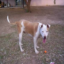

label:2


In [10]:
train_features, train_labels = next(iter(data_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
make = ToPILImage()
make(train_features[0]).show()
print(f'label:{train_labels[0]}')

In [11]:
# modified from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3,1 )
        
        self.fc1 = nn.Linear(6272 , 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 37)
        
        self.dropout1 = nn.Dropout(0.25)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool((self.conv1(x)))
        x = self.pool((self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        y_pred = self.fc3(x)
        return y_pred



In [12]:
net = ConvNet()
net.to(device)

ConvNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=6272, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=37, bias=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (relu): ReLU()
)

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [14]:
def train_x(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 1000 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [15]:
%time
for epoch in range(2):
    train_x(net,device,data_loader, optimizer, epoch) 
    
state_dict = net.state_dict()
consume_prefix_in_state_dict_if_present(state_dict, "module.")        

print('Finished Training')

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.96 µs
Train Epoch: 0 [0/3680 (0%)]	Loss: 3.612373
Train Epoch: 1 [0/3680 (0%)]	Loss: 3.586359
Finished Training


In [16]:
torch.save(state_dict, "model.torch")

In [17]:
# Now with Ray 

In [18]:
dataset_factory = lambda: torchvision.datasets.OxfordIIITPet("data/", download = True, target_types = "category", transform = transforms, split = "trainval")
dataset = ray.data.read_datasource(
    SimpleTorchDatasource(), parallelism=1, dataset_factory=dataset_factory
)

Caught schedule exception
2022-08-09 23:14:53,470	INFO common.py:219 -- Exception from actor creation is ignored in destructor. To receive this exception in application code, call a method on the actor reference before its destructor is run.


In [19]:
#dataset = dataset.repartition(2)

In [20]:
def train_epoch(dataloader, model, loss_fn, optim):
    model.train()
    for batch_idx, data in enumerate(dataloader.iter_batches()):
        X = [x[0] for x in data]
        X = torch.stack(X)
        X = X.to("cuda")
        y = [torch.tensor(x[1]) for x in data]
        y = torch.stack(y)
        y = y.to("cuda") 
        pred = model(X)
        loss = loss_fn(pred, y) 
        
        #backprop
        optim.zero_grad()
        loss.backward()
        optim.step()
        
    return loss

In [21]:
def train_func(config):
    batch_size = config["batch_size"]
    lr = config["lr"]
    epochs = config["epochs"]
    momentum = config["momentum"]
    
    worker_batch_size = batch_size // train.world_size()
    train_dataloader = dataset
    model = ConvNet()
    model = train.torch.prepare_model(model)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr,  momentum=momentum)
    
    loss_results = []
    
    for epoch in range(epochs):
        loss = train_epoch(train_dataloader, model, loss_fn, optimizer)
        if epoch % 10 == 0:
             print(f"epoch:{epoch}  loss {loss:>7f}")
            
        if epoch == epochs-1:
            state_dict = model.state_dict()
            consume_prefix_in_state_dict_if_present(state_dict, "module.")
            train.save_checkpoint(epoch=epochs, model_weights=state_dict)
            
    

In [22]:
%%time
if os.environ.get('RAY_CLUSTER') is not None:
    num_workers = 2
else:
    num_workers = 1

trainer = Trainer(backend="torch", num_workers=num_workers, use_gpu=True)

2022-08-09 23:15:00,065	INFO trainer.py:243 -- Trainer logs will be logged in: /opt/app-root/src/ray_results/train_2022-08-09_23-15-00


CPU times: user 7.47 ms, sys: 2.13 ms, total: 9.6 ms
Wall time: 610 ms


In [23]:
%%time
trainer.start()# This keeps starting new workers 

CPU times: user 30.5 ms, sys: 11.3 ms, total: 41.8 ms
Wall time: 16.1 s


(BaseWorkerMixin pid=2141) 2022-08-09 23:15:16,587	INFO torch.py:346 -- Setting up process group for: env:// [rank=0, world_size=2]
(BaseWorkerMixin pid=158, ip=10.129.5.88) 2022-08-09 23:15:16,628	INFO torch.py:346 -- Setting up process group for: env:// [rank=1, world_size=2]


In [ ]:
%%time
trainer.run(train_func=train_func,
        config={"lr": 0.01, "batch_size": 4, "epochs": 500, "momentum":0.9}) 


In [25]:
results = trainer.latest_checkpoint
#consume_prefix_in_state_dict_if_present(results, "module.")
torch.save(results["model_weights"], "dist_model.torch")

In [26]:
%%time
trainer.shutdown()

CPU times: user 3.07 ms, sys: 100 µs, total: 3.17 ms
Wall time: 45.7 ms


In [27]:
model = ConvNet()
model.to(device)
model.load_state_dict(torch.load("dist_model.torch"))
model.eval()

(BaseWorkerMixin pid=158, ip=10.129.5.88) E0809 23:19:50.869524168     199 chttp2_transport.cc:1103]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


ConvNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=6272, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=37, bias=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (relu): ReLU()
)

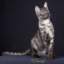

label:11
prediction: 11


In [28]:
train_features, train_labels = next(iter(data_loader))
make = ToPILImage()
make(train_features[0]).show()
print(f'label:{train_labels[0]}')
logits = model(train_features[0].reshape(1,3,64,64).to(device))
print(f"prediction: {torch.argmax(logits).item()}")

In [29]:
y_preds = []
gt = []
for X,y in data_loader:
    logits = model(X[0].reshape(1,3,64,64).to(device))
    y_pred = torch.argmax(logits).item()
    y_preds.append(y_pred)
    gt.append(y[0].item())

In [30]:
print(classification_report(y_preds,gt))

              precision    recall  f1-score   support

           0       0.58      0.47      0.52        32
           1       0.41      0.47      0.44        19
           2       0.43      0.39      0.41        23
           3       0.65      0.65      0.65        20
           4       0.57      0.81      0.67        16
           5       0.20      0.44      0.28         9
           6       0.67      0.67      0.67        24
           7       0.87      0.79      0.83        33
           8       0.48      0.80      0.60        15
           9       0.61      0.44      0.51        25
          10       0.39      0.46      0.42        24
          11       0.90      0.55      0.68        33
          12       0.39      0.67      0.49        18
          13       0.61      0.56      0.58        34
          14       0.78      0.64      0.71        28
          15       0.50      0.63      0.56        19
          16       0.35      0.69      0.47        16
          17       0.92    

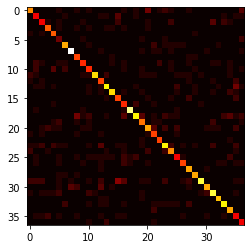

In [31]:
plt.imshow(confusion_matrix(y_preds,gt), cmap='hot', interpolation='nearest')
plt.show()

In [32]:
print(f"Accuracy: {np.sum(np.array(y_preds)==np.array(gt))/(len(gt))*100:.1f}%")
print(f"Random guess would yield {(1/37)*100:.1f}%")
print(f"Model outperforms Random chance by a factor of {(np.sum(np.array(y_preds)==np.array(gt))/len(gt))/(1/37):.2f}")

Accuracy: 58.7%
Random guess would yield 2.7%
Model outperforms Random chance by a factor of 21.72
